### Can AR(2) coefficient features be discriminated for interictal and preictal classes?

In [1]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

In [3]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1 * np.ones(data.shape[1])
    return data, target

In [4]:
# ARMA parameters
seed = 42
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = 23                 # Number of EEG electrodes (channels)
m = 30                   # MA parameter
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
ar = ARMA(window_width=N, order=n_i, memory=m, seed=seed)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [8]:
# load preictal and interictal data
preictal_feature_list = []
interictal_feature_list = []
for i in range(6):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, _ = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    _, _, preictal_features = ar.spin(sig=p_data, fs=256)
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, _ = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    _, _, interictal_features = ar.spin(sig=ic_data[:,:p_data.shape[1]], fs=256)
    
    # store data in list
    preictal_feature_list.append(preictal_features)
    interictal_feature_list.append(interictal_features)

100%|██████████| 229887/229887 [00:02<00:00, 114373.45it/s]


### Sample 1

In [15]:
preictal_feature_list[0].shape

(449, 23, 2)

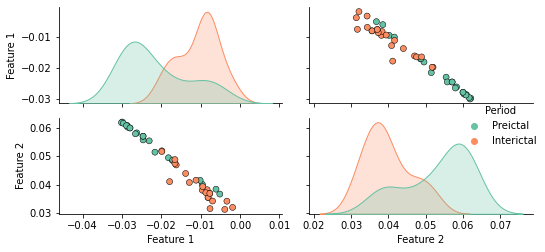

In [126]:
df_1 = pd.DataFrame(preictal_feature_list[0][448,:,:], columns=['Feature 1', 'Feature 2'])
df_1['Period'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[0][448,:,:], columns=['Feature 1', 'Feature 2'])
df_2['Period'] = 'Interictal'
frames = [df_1, df_2]
rdf = pd.concat(frames)

palette = sns.color_palette("Set2", n_colors=2)
sns.pairplot(rdf, hue='Period', height=1.8, aspect=1.8, palette=palette,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/AR_sample_distr.pdf')
plt.show()

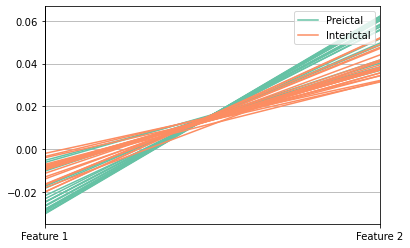

In [113]:
pc = parallel_coordinates(rdf, 'Period', color=palette)

### Sample 2

In [29]:
df_1 = pd.DataFrame(preictal_feature_list[2][448,:,:], columns=['Feature 1', 'Feature 2'])
df_1['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[2][448,:,:], columns=['Feature 1', 'Feature 2'])
df_2['Interval'] = 'Interictal'
frames = [df_1, df_2]
rdf = pd.concat(frames)

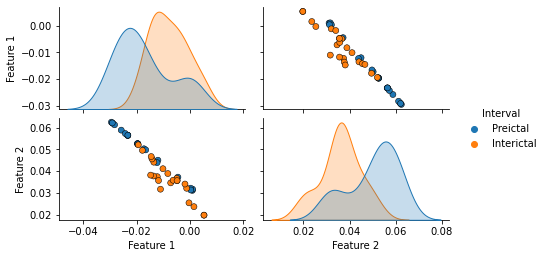

In [30]:
sns.pairplot(rdf, hue='Interval', height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

### Sample 3

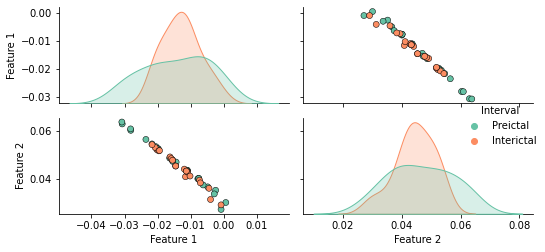

In [125]:
df_1 = pd.DataFrame(preictal_feature_list[3][448,:,:], columns=['Feature 1', 'Feature 2'])
df_1['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[3][448,:,:], columns=['Feature 1', 'Feature 2'])
df_2['Interval'] = 'Interictal'
frames = [df_1, df_2]
rdf = pd.concat(frames)


palette = sns.color_palette("Set2", n_colors=2)
sns.pairplot(rdf, hue='Interval', height=1.8, aspect=1.8, palette=palette,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/AR_sample_distr.pdf')
plt.show()

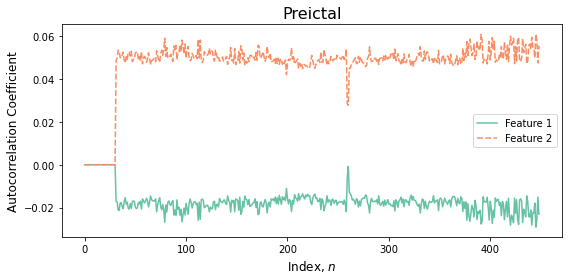

In [124]:
# AR response during preictal
# select single channel, all time, both AR coeffs.
d = preictal_feature_list[0][:,0,:]
df = pd.DataFrame(data=d, columns=['Feature 1', 'Feature 2'])

plt.figure(figsize=(8,4))
palette = sns.color_palette("Set2", n_colors=2)
sns.lineplot(data=df, palette=palette)
plt.xlabel(r'Index, $n$', fontsize=12)
plt.ylabel('Autocorrelation Coefficient', fontsize=12)
plt.title('Preictal', fontsize=16)
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/AR_resp_preictal.pdf')
plt.show()

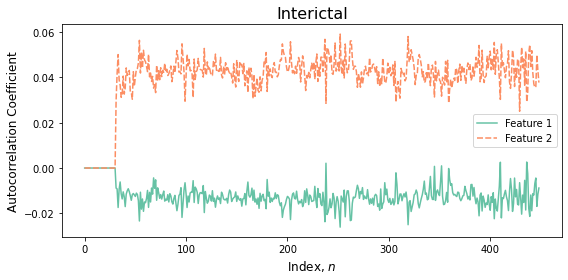

In [123]:
# AR response during interictal
# select single channel, all time, both AR coeffs.
d = interictal_feature_list[0][:,0,:]
df = pd.DataFrame(data=d, columns=['Feature 1', 'Feature 2'])

plt.figure(figsize=(8,4))
palette = sns.color_palette("Set2", n_colors=2)
sns.lineplot(data=df, palette=palette)
plt.xlabel(r'Index, $n$', fontsize=12)
plt.ylabel('Autocorrelation Coefficient', fontsize=12)
plt.title('Interictal', fontsize=16)
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/AR_resp_interictal.pdf')
plt.show()